# Notebook de test sobre PyTorch

## Instal·lació de dependències

In [1]:
!pip install torch torchvision pycocotools

  Installing build dependencies ... - \ | / - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp37-cp37m-linux_x86_64.whl size=373765 sha256=b4f1201c1bb84b99ac44c4e8f2e907e034853e474340f87b4bd3087411e83f30
  Stored in directory: /root/.cache/pip/wheels/06/f6/f9/9cc49c6de8e3cf27dfddd91bf46595a057141d4583a2adaf03
Successfully built pycocotools


In [2]:
import torch
import cv2
import numpy as np
import os
import glob as glob
import csv

In [3]:
single_class = False
supercategories = True

In [4]:
if single_class:
    classes = ['background', 'traffic_sign']
else:
    if supercategories:
        classes = ['background', 'prohibitory', 'danger', 'mandatory', 'other']
    classes = [
        "background",
        "speed limit 20 (prohibitory)",
        "speed limit 30 (prohibitory)",
        "speed limit 50 (prohibitory)",
        "speed limit 60 (prohibitory)",
        "speed limit 70 (prohibitory)",
        "speed limit 80 (prohibitory)",
        "restriction ends 80 (other)",
        "speed limit 100 (prohibitory)",
        "speed limit 120 (prohibitory)",
        "no overtaking (prohibitory)",
        "no overtaking (trucks) (prohibitory)",
        "priority at next intersection (danger)",
        "priority road (other)",
        "give way (other)",
        "stop (other)",
        "no traffic both ways (prohibitory)",
        "no trucks (prohibitory)",
        "no entry (other)",
        "danger (danger)",
        "bend left (danger)",
        "bend right (danger)",
        "bend (danger)",
        "uneven road (danger)",
        "slippery road (danger)",
        "road narrows (danger)",
        "construction (danger)",
        "traffic signal (danger)",
        "pedestrian crossing (danger)",
        "school crossing (danger)",
        "cycles crossing (danger)",
        "snow (danger)",
        "animals (danger)",
        "restriction ends (other)",
        "go right (mandatory)",
        "go left (mandatory)",
        "go straight (mandatory)",
        "go right or straight (mandatory)",
        "go left or straight (mandatory)",
        "keep right (mandatory)",
        "keep left (mandatory)",
        "roundabout (mandatory)",
        "restriction ends (overtaking) (other)",
        "restriction ends (overtaking (trucks)) (other)"
    ]


### Desarreguem el dataset de GTSDB

In [5]:
!wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
!unzip FullIJCNN2013.zip
!mv FullIJCNN2013/ GTSDB/

--2023-01-09 14:43:00--  https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1661866983 (1.5G) [application/zip]
Saving to: ‘FullIJCNN2013.zip’

FullIJCNN2013.zip   100%[===================>]   1.55G  19.7MB/s    in 83s     

2023-01-09 14:44:23 (19.2 MB/s) - ‘FullIJCNN2013.zip’ saved [1661866983/1661866983]

Archive:  FullIJCNN2013.zip
   creating: FullIJCNN2013/
   creating: FullIJCNN2013/00/
  inflating: FullIJCNN2013/00000.ppm  
  inflating: FullIJCNN2013/00001.ppm  
  inflating: FullIJCNN2013/00002.ppm  
  inflating: FullIJCNN2013/00003.ppm  
  inflating: FullIJCNN2013/00004.ppm  
  inflating: FullIJCNN2013/00005.ppm  
  inflating: FullIJCNN2013/00006.ppm  
  inflating: FullIJCNN2013/00007.ppm  
  inflating: FullIJCNN2013/00008.ppm  
  inflating: FullIJCNN2013/00009.

### Afegim uns quants fitxers de torchvision amb funcions útils

In [6]:

!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.8.2

!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../

%cd ../


Cloning into 'vision'...
remote: Enumerating objects: 277558, done.
remote: Counting objects: 100% (16873/16873), done.
remote: Compressing objects: 100% (809/809), done.
remote: Total 277558 (delta 16105), reused 16762 (delta 16031), pack-reused 260685
Receiving objects: 100% (277558/277558), 557.33 MiB | 34.32 MiB/s, done.
Resolving deltas: 100% (253783/253783), done.
/kaggle/working/vision
Note: switching to 'v0.8.2'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 2f40a483d7 [v0.8.X] .circleci: Add Python 3

## Definició del Dataset

In [7]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image


class GTSDB_dataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None, single_class=False, supercategories=False):
        self.transforms = transforms #Les transformacions que volem fer per data augmentation
        self.dir_path = dir_path     #Directori de les imatges a entrenar
        self.height = height         #Mida de les imatges
        self.width = width 
        self.classes = classes       #Llista amb els noms de les classes

        #self.image_paths = glob.glob(f"{self.dir_path}/*.ppm") # Obtenim el path de cada imatge
        #self.all_images = [image_path.split('/')[-1] for image_path in self.image_paths] #Obtenim el filename de cada imatge
        #self.all_images = sorted(self.all_images)
        
        # Obtenim les deteccions de cada imatge
        self.detections = dict()
        self.all_images = set()

        with open(dir_path + 'gt.txt') as file:
            reader = csv.reader(file, delimiter=';')
            for i in reader:
                if single_class:
                    self.detections.setdefault(i[0], []).append({'box': list(map(int, i[1:5])), 'class': 1})
                else:
                    if supercategories:
                        cat = 0
                        if int(i[-1]) in [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16]: 
                            cat = 0
                        elif int(i[-1]) in [11, 18,19, 20, 21, 22, 23, 24, 25,26, 27, 28, 29, 30, 31]:
                            cat = 1
                        elif int(i[-1]) in [33, 34, 35, 36, 37, 38, 39, 40]:
                            cat = 2
                        else:
                            cat = 3
                        self.detections.setdefault(i[0], []).append({'box': list(map(int, i[1:5])), 'class': cat + 1})
                    else:
                        self.detections.setdefault(i[0], []).append({'box': list(map(int, i[1:5])), 'class': int(i[-1]) + 1}) 
                
                self.all_images.add(i[0])
        
        self.all_images = sorted(list(self.all_images))
        
    def __getitem__(self, idx):
        # Obtenim el filename i path de la imatge en índex idx
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        
        # Llegim la imatge amb OpenCV
        #image = cv2.imread(image_path)
        # I hi fem les conversions típiques d'invertir els canals, normalitzat i fer resize a la mida que volem
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #image_resized = cv2.resize(image, (self.width, self.height))
        #image_resized /= 255.0
                
        #mage_resized = torch.as_tensor(image_resized, dtype=torch.float32)
        
        
        image = Image.open(image_path).convert("RGB") #Carreguem la imatge
        image_width, image_height = image.size #Abans de fer el resize, guardem la mida per escalar les bounding boxes
        image = image.resize((self.width, self.height)) #Ara ja podem fer el resize
        
        boxes = []
        labels = []      
        
        # box coordinates for xml files are extracted and corrected for image size given
        for detection in self.detections[image_name]:
            # map the current object name to `classes` list to get...
            # ... the label index and append to `labels` list
            #labels.append(self.classes[detection['class']])
            labels.append(detection['class'])
            
            [xmin, ymin, xmax, ymax] = detection['box']
            
            # Fem el resize de la bouning box segons la `width` i `height` del resize, no de la real
            xmin_final = (xmin/image_width)*self.width
            xmax_final = (xmax/image_width)*self.width
            ymin_final = (ymin/image_height)*self.height
            yamx_final = (ymax/image_height)*self.height
            
            boxes.append([xmin_final, ymin_final, xmax_final, yamx_final])
        
        # Passem boxes a tensors 
        #print("Boxes", boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        #print("Tensors", boxes)
        # Calculem la àrea de les bounding boxes
        #print(boxes.size(), self.detections[image_name])
        if boxes.dim() == 1:
            area = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        else:
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # no crowd (??)
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        # labels a tensors
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        # muntem el diccionari `target` per retornar
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        
        # Apliquem les transformacions indicades per a data augmentation
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        #return image_resized, target
        return image, target
    
    def __len__(self):
        return len(self.all_images)

### Iteració per comprovar passem al model el que espera

In [8]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train: 
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = GTSDB_dataset('GTSDB/', 1280, 736, classes, get_transform(train=False), single_class, supercategories)
print(len(dataset))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=1, collate_fn=utils.collate_fn)

images,targets = next(iter(data_loader))
print([t.items for t in targets])
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)

#model.eval()
#x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
#predictions = model(x) 

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

741
[<built-in method items of dict object at 0x7f262b20fc80>, <built-in method items of dict object at 0x7f262b220c80>]


In [9]:
output

{'loss_classifier': tensor(0.4164, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.0158, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.0381, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0011, grad_fn=<DivBackward0>)}

## Entrenament

In [10]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


if single_class:
    num_classes = 2
else:
    if supercategories:
        num_classes = 4 + 1
    else:
        num_classes = 43 + 1 
    
# use our dataset and defined transformations
global_dataset = GTSDB_dataset('GTSDB/', 1280, 736, classes, get_transform(train=False), single_class, supercategories)

train_dataset, test_dataset = torch.utils.data.random_split(global_dataset, [541, 200], generator=torch.Generator().manual_seed(42))

# define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

#Build model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)
#model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#in_features = model.roi_heads.box_predictor.cls_score.in_features
#model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [11]:
losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []

In [12]:
# let's train it for 10 epochs
num_epochs = 20

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    metrics = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    coco_ev = evaluate(model, test_loader, device=device)
    
    stat = coco_ev.coco_eval['bbox'].stats
    
    stat0.append(stat[0])
    stat1.append(stat[1])
    stat2.append(stat[2])
    stat3.append(stat[3])
    stat4.append(stat[4])
    stat5.append(stat[5])
    stat6.append(stat[6])
    stat7.append(stat[7])
    stat8.append(stat[8])
    stat9.append(stat[9])
    stat10.append(stat[10])
    stat11.append(stat[11])

Epoch: [0]  [  0/271]  eta: 0:35:33  lr: 0.000024  loss: 2.2588 (2.2588)  loss_classifier: 1.5560 (1.5560)  loss_box_reg: 0.0006 (0.0006)  loss_objectness: 0.6971 (0.6971)  loss_rpn_box_reg: 0.0051 (0.0051)  time: 7.8736  data: 0.5925  max mem: 2481
Epoch: [0]  [ 50/271]  eta: 0:01:47  lr: 0.000949  loss: 0.3768 (1.1108)  loss_classifier: 0.1264 (0.5994)  loss_box_reg: 0.0103 (0.0193)  loss_objectness: 0.1412 (0.4759)  loss_rpn_box_reg: 0.0131 (0.0161)  time: 0.3387  data: 0.0132  max mem: 2745
Epoch: [0]  [100/271]  eta: 0:01:10  lr: 0.001873  loss: 0.3447 (0.7391)  loss_classifier: 0.1329 (0.3809)  loss_box_reg: 0.1310 (0.0786)  loss_objectness: 0.0372 (0.2644)  loss_rpn_box_reg: 0.0109 (0.0152)  time: 0.3431  data: 0.0150  max mem: 2745
Epoch: [0]  [150/271]  eta: 0:00:47  lr: 0.002798  loss: 0.3130 (0.6182)  loss_classifier: 0.1282 (0.3079)  loss_box_reg: 0.1263 (0.1015)  loss_objectness: 0.0375 (0.1937)  loss_rpn_box_reg: 0.0087 (0.0150)  time: 0.3354  data: 0.0130  max mem: 2745


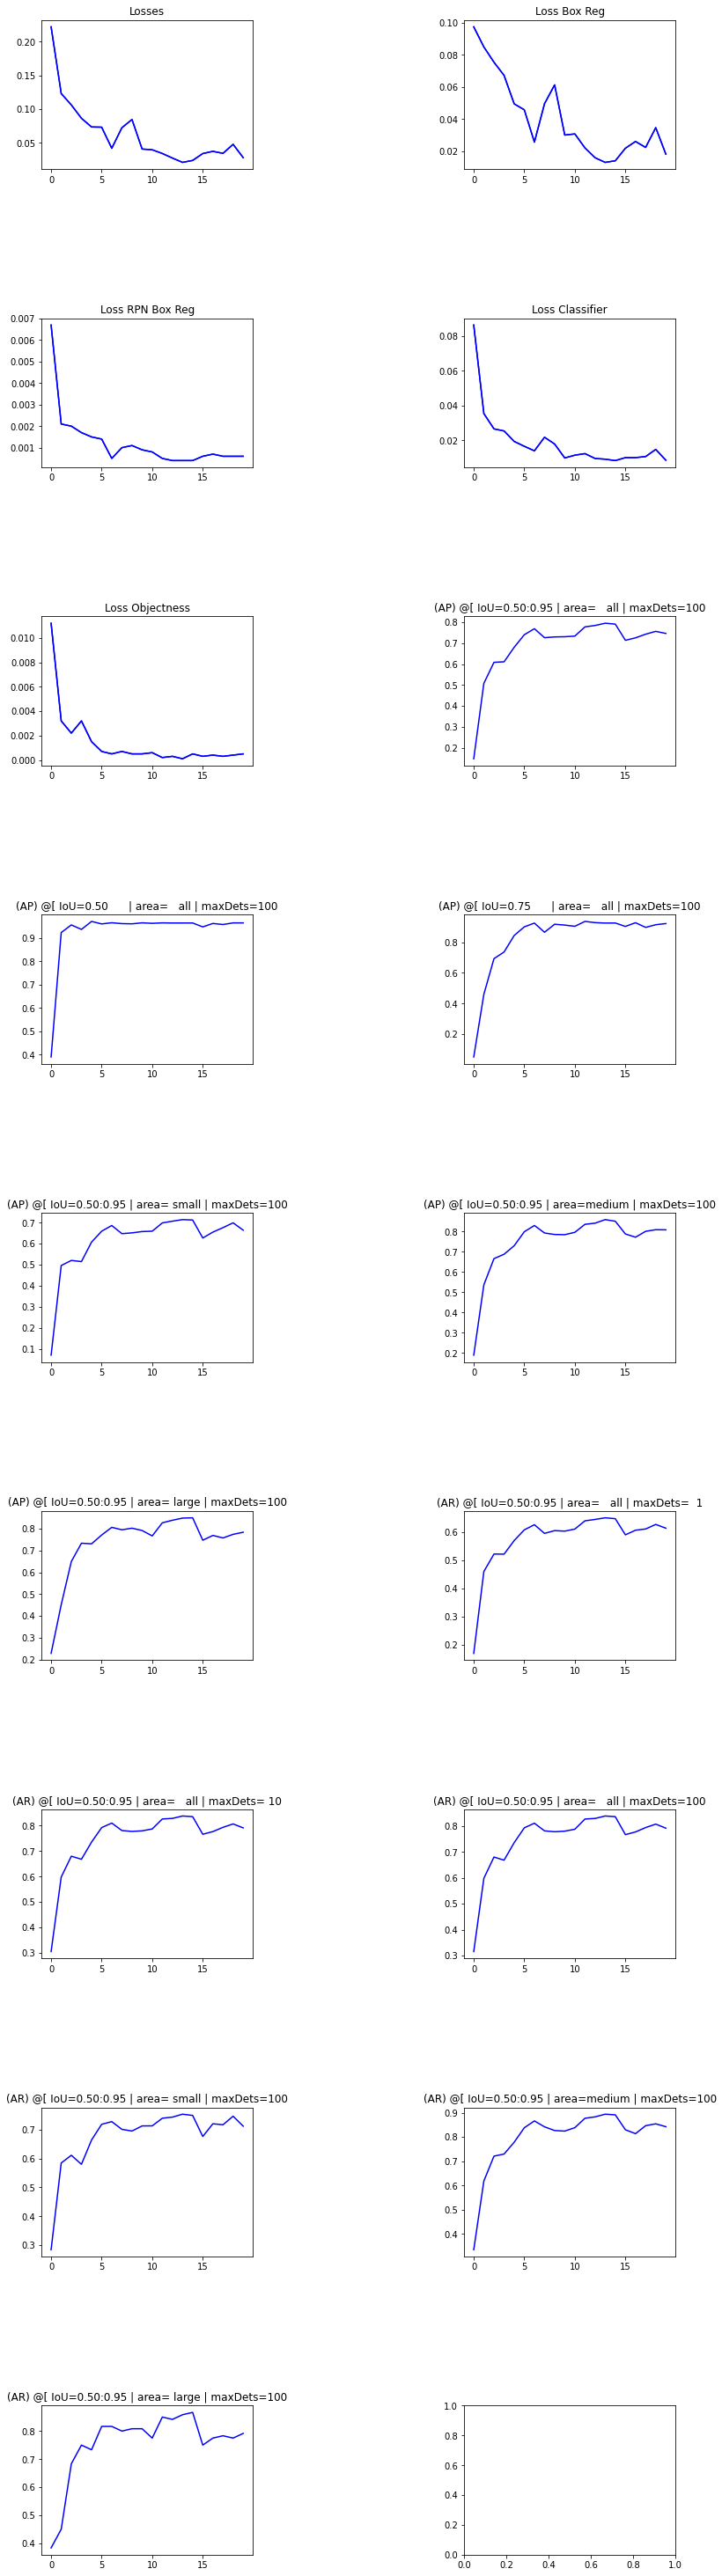

In [13]:
import matplotlib.pyplot as plt

r,c = 9,2
fig, ax = plt.subplots(nrows=r, ncols=c)
fig.set_figheight(40)
fig.set_figwidth(10)
fig.subplots_adjust(left=14,right=15, top=6, bottom=5, hspace=1, wspace=1)


ax1 = plt.subplot(r, c, 1)
ax1.set_title("Losses")
ax2 = plt.subplot(r, c, 2)
ax2.set_title("Loss Box Reg")
ax3 = plt.subplot(r, c, 3)
ax3.set_title("Loss RPN Box Reg")
ax4 = plt.subplot(r, c, 4)
ax4.set_title("Loss Classifier")
ax5 = plt.subplot(r, c, 5)
ax5.set_title("Loss Objectness")
ax6 = plt.subplot(r, c, 6)
ax6.set_title("(AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax7 = plt.subplot(r, c, 7)
ax7.set_title("(AP) @[ IoU=0.50      | area=   all | maxDets=100")
ax8 = plt.subplot(r, c, 8)
ax8.set_title("(AP) @[ IoU=0.75      | area=   all | maxDets=100")
ax9 = plt.subplot(r, c, 9)
ax9.set_title("(AP) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax10 = plt.subplot(r, c, 10)
ax10.set_title("(AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax11 = plt.subplot(r, c, 11)
ax11.set_title("(AP) @[ IoU=0.50:0.95 | area= large | maxDets=100")
ax12 = plt.subplot(r, c, 12)
ax12.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1")
ax13 = plt.subplot(r, c, 13)
ax13.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10")
ax14 = plt.subplot(r, c, 14)
ax14.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax15 = plt.subplot(r, c, 15)
ax15.set_title("(AR) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax16 = plt.subplot(r, c, 16)
ax16.set_title("(AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax17 = plt.subplot(r, c, 17)
ax17.set_title("(AR) @[ IoU=0.50:0.95 | area= large | maxDets=100")

ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax6.plot(stat0, 'b')
ax7.plot(stat1, 'b')
ax8.plot(stat2, 'b')
ax9.plot(stat3, 'b')
ax10.plot(stat4, 'b')
ax11.plot(stat5, 'b')
ax12.plot(stat6, 'b')
ax13.plot(stat7, 'b')
ax14.plot(stat8, 'b')
ax15.plot(stat9, 'b')
ax16.plot(stat10, 'b')
ax17.plot(stat11, 'b')
plt.show()

In [14]:
import pickle

torch.save(model, r'./train1000.pkl')

torch.save(model.state_dict(), 'train1000.pth')
torch.save({
    'epoch' : epoch,
    "model_state_dict" : model.state_dict(),
    'optimizer_state_dict' : optimizer.state_dict(),
}, 'ckpt1000.pth')
with open('vars1000.pickle', 'wb') as f:
    pickle.dump([losses, loss_box_reg, loss_rpn_box_reg, loss_classifier, loss_objectness, stat0, stat1, stat2, stat3,
 stat4, stat5, stat6, stat7, stat8, stat9, stat10, stat11], f)

In [15]:
import pickle

In [16]:
# pick one image from the test set
img, _ = test_dataset[0]
print(img, _)
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
print(prediction)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.8706, 0.9882, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.9059, 1.0000],
         ...,
         [1.0000, 0.9216, 0.0745,  ..., 0.0000, 0.9098, 1.0000],
         [1.0000, 0.9176, 0.0706,  ..., 0.0000, 0.9098, 1.0000],
         [1.0000, 0.9176, 0.0706,  ..., 0.0000, 0.9098, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.8745, 0.9882, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.9137, 1.0000],
         ...,
         [1.0000, 0.9216, 0.0784,  ..., 0.1020, 0.9216, 1.0000],
         [1.0000, 0.9216, 0.0784,  ..., 0.0941, 0.9216, 1.0000],
         [1.0000, 0.9216, 0.0784,  ..., 0.0941, 0.9216, 1.0000]],

        [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.8706, 0.9882, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.9059, 1.